__What is torch.nn really?__

1. [Load tools](#Load-tools)
1. [MNIST data setup](#MNIST-data-setup)
1. [Neural net from scratch (no torch.nn)](#Neural-net-from-scratch-(no-torch.nn))
1. [Using torch.nn.functional](#Using-torch.nn.functional)
1. [Refactoring](#Refactoring)
    1. [Refactor using nn.Module](#Refactor-using-nn.Module)
    1. [Refactor using nn.Linear](#Refactor-using-nn.Linear)
    1. [Refactor using optim](#Refactor-using-optim)
    1. [Refactor using Dataset](#Refactor-using-Dataset)
    1. [Refactor using DataLoader](#Refactor-using-DataLoader)
1. [Add validation](#Add-validation)
1. [Create fit() and get_data()](#Create-fit()-and-get_data())
1. [From logistic regression to CNN](#From-logistic-regression-to-CNN)
    1. [nn.Sequential](#nn.Sequential)
    1. [Wrapping DataLoader](#Wrapping-DataLoader)
1. [Using a GPU](#Using-a-GPU)

# Load tools

<a id = 'Load-tools'></a>

In [1]:
# Standard libary and settings
import os
import sys
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# Data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# import PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.jit import script, trace
import torchvision
import torchvision.transforms as transforms

# Visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# Magic functions
%matplotlib inline

# MNIST data setup

<a id = 'MNIST-data-setup'></a>

In [2]:
# download pickle obect containing the MNIST data set
from pathlib import Path
import requests

DATA_PATH = Path("C:/users/petersont/desktop/data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [3]:
# deserialize pickled dataset
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((X_train, y_train), (X_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

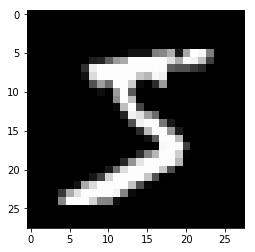

In [4]:
# print sample
plt.imshow(X_train[0].reshape((28, 28)), cmap="gray")

In [5]:
# convert dataset from numpy arrays to torch.tensors
# X_train, y_train, X_valid, y_valid = map(torch.tensor
#                                          ,(X_train, y_train, X_valid, y_valid)
#                                         )
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
# y_train = torch.tensor(y_train, dtype = torch.long)

X_valid = torch.tensor(X_valid)
y_valid = torch.tensor(y_valid)
# y_valid = torch.tensor(y_valid, dtype = torch.long)

print(X_train.dtype)
print(y_train.dtype)
print(X_valid.dtype)
print(y_valid.dtype)

torch.float32
torch.int64
torch.float32
torch.int64


# Neural net from scratch (no torch.nn)

This first model is created by using only PyTorch tensor operations. PyTorch provides methods to create tensors of random numbers and tensors of zeros, which can be used to initialize weights and biases. These are regular tensors with the addition of a flag that inidcates that we will calculate and track gradients.

<a id = 'Neural-net-from-scratch-(no-torch.nn)'></a>

In [6]:
import math

# initialize weights using Xavier initialization (multiplying by 1 / sqrt(n))
# this gradient requirement is turned on in place using requires_grad_ after initialization so that we can avoid
# including the initialization in the gradient
weights = torch.randn(X_valid.shape[1], 10) / math.sqrt(X_valid.shape[1])
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [7]:
# create softmax activation function and a matrix multiplication / broadcasted addition fuctnoin
# the @ symbol stands for the dot product operation
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)


def model(xb):
    #     return log_softmax(xb)
    return log_softmax(xb @ weights + bias)

In [8]:
# call function on one batch of 64 samples. This completes one forward pass, which provides predictions
bs = 64

xb = X_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3258, -1.8679, -1.7082, -2.8431, -2.4349, -2.2484, -2.5516, -2.6943,
        -2.5078, -2.4278], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [9]:
# implement negative log-likelihood as the loss function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()


loss_func = nll

In [10]:
# set baseline
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4351, grad_fn=<NegBackward>)


In [11]:
# accuracy function which checks to see if the index of the largest value in the predicted probabilities
# vector matches the target value
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


print(accuracy(preds, yb))

tensor(0.0781)


In [12]:
# set up a training loop. the end result is a train logistc regression model (no hidden layers)
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((X_train.shape[0] - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print("epoch complete")
#         print('batch complete')
#         break

epoch complete
epoch complete


In [13]:
#
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0839, grad_fn=<NegBackward>)
tensor(1.)


# Using torch.nn.functional

This example will begin to take advantage of PyTorch's nn classes to make thing more concise and flexible. torch.nn.functional includes implementations of the handwritten function written above.

<a id = 'Using-torch.nn.functional'></a>

In [14]:
# replacement for log softmax activation and negative log likelihood functions
loss_func = F.cross_entropy


def model(xb):
    return xb @ weights + bias

In [15]:
# ensure results are the same with the new model function
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0839, grad_fn=<NllLossBackward>)
tensor(1.)


# Refactoring

<a id = 'Refactoring'></a>

## Refactor using nn.Module

<a id = 'Refactor-using-nn.Module'></a>

In [16]:
#
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias


model = MnistLogistic()
print(loss_func(model(xb), yb))

tensor(2.3410, grad_fn=<NllLossBackward>)


In [17]:
def fit():
    for epoch in range(epochs):
        for i in range((X_train.shape[0] - 1) // bs + 1):
            #         set_trace()
            start_i = i * bs
            end_i = start_i + bs
            xb = X_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            # we no longer need to update each value by name then manually zero out the
            # grads for each parameter separately
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        print("epoch complete")


fit()
print(loss_func(model(xb), yb))

epoch complete
epoch complete
tensor(0.0798, grad_fn=<NllLossBackward>)


##  Refactor using nn.Linear

Instead of manually defining and initializing self.weights and self.bias, and calculating xb @ self.weights + self.bias, we can just use the PyTorch class nn.Linear for a linear layer to accomplish all of that in a tidy workflow.

<a id = 'Refactor-using-nn.Linear'></a>

In [18]:
#
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(in_features=784, out_features=10)

    def forward(self, xb):
        return self.lin(xb)


model = MnistLogistic()
print(loss_func(model(xb), yb))

fit()
print(loss_func(model(xb), yb))

tensor(2.3584, grad_fn=<NllLossBackward>)
epoch complete
epoch complete
tensor(0.0820, grad_fn=<NllLossBackward>)


## Refactor using optim

PyTorch includes a package called torch.optim that contains several optimization algorithms. We can use its step method to execute the weight updates rather than udpating each step manually

<a id = 'Refactor-using-optim'></a>

In [19]:
def fit(opt):
    for epoch in range(epochs):
        for i in range((X_train.shape[0] - 1) // bs + 1):
            #         set_trace()
            start_i = i * bs
            end_i = start_i + bs
            xb = X_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
        print("epoch complete")

In [20]:
#
def get_model():
    model = MnistLogistic()
    return model, optim.SGD(model.parameters(), lr=lr)


model, opt = get_model()
print(loss_func(model(xb), yb))

fit(opt)

print(loss_func(model(xb), yb))

tensor(2.2842, grad_fn=<NllLossBackward>)
epoch complete
epoch complete
tensor(0.0812, grad_fn=<NllLossBackward>)


## Refactor using Dataset

A PyTorch dataset can be anything that has a len function and a getitem function. 

<a id = 'Refactor-using-Dataset'></a>

In [21]:
# combine image and label into a single TensorDataset
from torch.utils.data import TensorDataset

train_ds = TensorDataset(X_train, y_train)

In [22]:
#
for epoch in range(epochs):
    for i in range((X_train.shape[0] - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
    print("epoch complete")

print(loss_func(model(xb), yb))

epoch complete
epoch complete
tensor(0.0654, grad_fn=<NllLossBackward>)


## Refactor using DataLoader

DataLoader is a helpful utilitiy for managing batches. A DataLoader can be created from any Dataset. It serves up each mini batch automatically rather which avoids the needs to dynamically slice through a dataset.

<a id = ''></a>

In [23]:
# setup DataLaoder for each batching
from torch.utils.data import DataLoader

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [24]:
#
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
    print("epoch complete")

print(loss_func(model(xb), yb))

epoch complete
epoch complete
tensor(0.0599, grad_fn=<NllLossBackward>)


# Add validation

Shuffling the training data is important so that we prevent correlation between batches, potentially leading to overfitting. We don't need to shuffle the validation set though, since the loss will be identical regardless. We can avoid this extra overhead.

We can use a larger batch size for the validation datast because we don't need to perform backpropagation and won't consume the extra memory involved with that operation. This will calculate the loss more quickly.

<a id = 'Add-validation'></a>

In [25]:
#
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [26]:
#
opt = optim.SGD(model.parameters(), lr=0.0001)
for epoch in range(3):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2759)
1 tensor(0.2749)
2 tensor(0.2739)


# Create fit() and get_data()

Since the process of calculating the loss on the training and validation sets is very similar, it's straightforward to put together a few utility functions to handle to anticipated operations.

<a id = 'Create-fit()-and-get_data()'></a>

In [27]:
# utility for calculating loss during train and test phase
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [28]:
# utility for running training operation, returns training and validation losses
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [29]:
#
def get_data(train_ds, valid_bs, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(train_ds, batch_size=bs * 2),
    )

In [30]:
print("done")

done


In [32]:
#
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()

epochs = 5
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34621355241775514
1 0.29948344000816346
2 0.32096873394966124
3 0.37013925053596497
4 0.2684114327144623


# From logistic regression to CNN

A convolutional neural network is much better suited for the task of image classification than logistic regression.

Many of the functions used above can be reused here. We do need to create a new model that utilizes nn.Conv2d

<a id = 'From-logistic-regression-to-CNN'></a>

In [36]:
#
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


lr = 0.1

In [37]:
# momentum is a variation on SGD that takes the previous updates into account. typically trains faster
# than vanilla SGD
model = MnistCNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

epochs = 5
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4246568864440918
1 0.2723297655963898
2 0.21715527342319488
3 0.21216361099720002
4 0.21444033586502076


## nn.Sequential

torch.nn.Sequential runs each of the specified models contained within it in sequence. This offers an easier way to write out a network.

If there isn't a buildin layer that executes something we need, then we need to create a custom layer class. PyTorch doesn't have view layer, so we need to create.

The Lambda class creates a layer than we can then use in a network defined by Sequential.

<a id = 'nn.Sequential'></a>

In [41]:
#
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [44]:
#
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

epochs = 5
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4266024195384979
1 0.3133797203540802
2 0.2837066837596893
3 0.25039003477096555
4 0.2021708907556534


## Wrapping DataLoader

We need to make the CNN work with datasets of any size. Right now it only works with the MNIST dataset dimensions. We will ensure the model works with any 2d single channel image. We can also remove the first lambda layer by moving the data preprocessing into a generator.

<a id = 'Wrapping-DataLoader'></a>

In [47]:
#
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [50]:
# replace nn.AvgPool2d with nn.AdaptiveAvgPool2d which enables defining the size of the output tensor
# we want rather than the input tensor we have. consequently the model will work with any size input
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

epochs = 15
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4133407281494141
1 0.38616921880722044
2 0.2285273023223877
3 0.2058594765520096
4 0.230983209028244
5 0.16013708847999572
6 0.1764500244474411
7 0.15155416670799254
8 0.13222848244667054
9 0.1271891475915909
10 0.15136579699516298
11 0.11074243953227997
12 0.10983089401245118
13 0.11350204944610595
14 0.09919491053581238


# Using a GPU

<a id = 'Using-a-GPU'></a>

In [51]:
#
print(torch.cuda.is_available())

False


In [53]:
#
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [59]:
# update preprocess to move tensors to GPU
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [60]:
# move model to GPU
model.to(device)

opt = optim.SGD(model.parameters(), lr=lr)

epochs = 5
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.07909365794897079
1 0.07740627563238144
2 0.07732470079183579
3 0.0757712667298317
4 0.07776396325111389


# Closing thoughts

There are several other operations that could potentially improve the model furhter: data augmentation (flipping images, cropping, rotating) hyperparameter tuning, monitoring training, transfer learning, etc.

<a id = 'Closing-thoughts'></a>